# 使用SSD来对模型进行简单的训练看一下效果

这里我们刚好学习完李沐的代码操作，就直接使用SSD来训练一下模型。
- 目前的开发平台是colab
- GPU是Tesla T4。

## 配置环境

在运行时记得第一步先上传`lastwork.zip`到左边文件目录中，而且在修改代码的时候不建议开GPU环境，而是在训练的时候再改成GPU环境，防止不知道什么时候被突然ban掉了。


### 查看GPU

In [1]:
!nvidia-smi

Thu Jun 29 06:32:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 上传并解压本地的写的包

In [2]:
import os
import zipfile
# 解压上传的lastwork.zip
filename = 'lastwork.zip'
# 解压缩文件
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./')

# 删除压缩文件
os.remove(filename)

### 安装需要的包

In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
 

### 导入需要的库

In [4]:
import torch

## 使用gradio查看锚框尺寸效果

In [5]:
# from utils.gradio import show_multi_anchors_app # 在训练时可以不执行这里

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5

# 将sizes和ratios转换为一维列表
# sizes1d = [size for sizes_per_layer in sizes for size in sizes_per_layer]
# ratios1d = ratios[0]

# show_multi_anchors_app(sizes1d, ratios1d)

## 定义模型

这里借鉴的是李沐d2l代码中的模型，下面是模型的结构图：

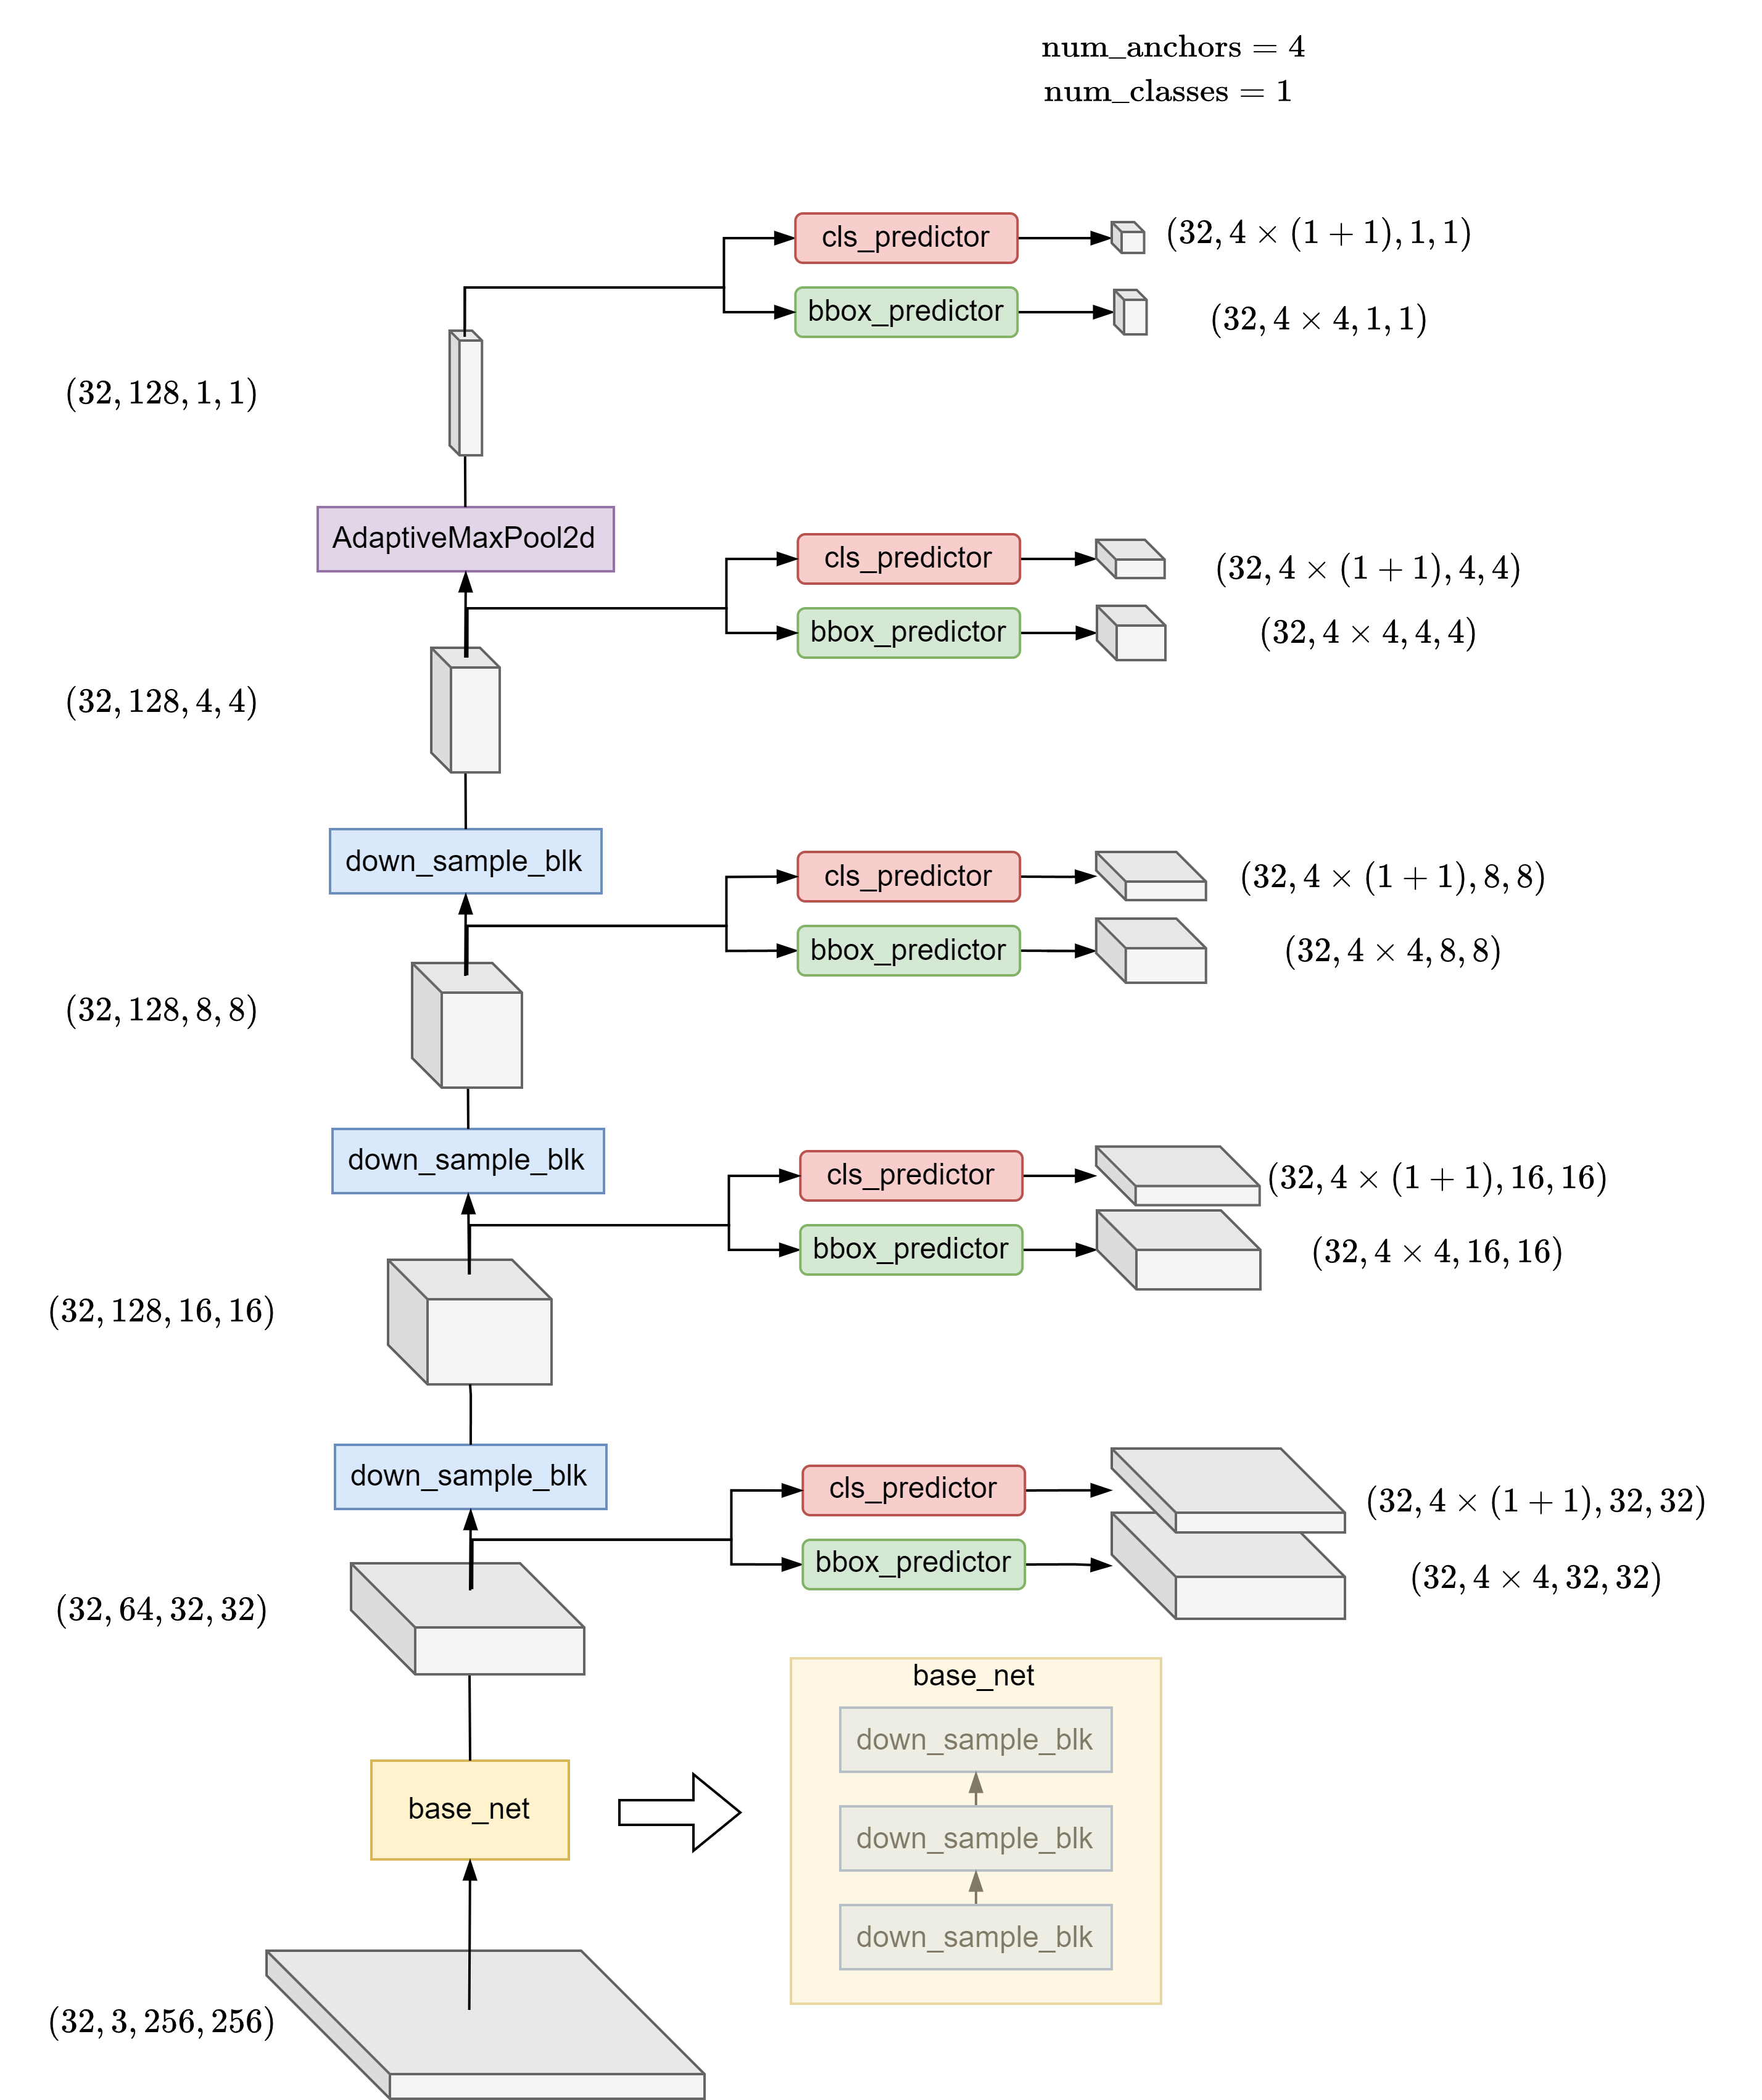


In [6]:
from utils.SSD import TinySSD

net = TinySSD(num_classes=22, sizes=sizes, ratios=ratios)

In [7]:
from torchinfo import summary

summary(net, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TinySSD                                  [1, 5444, 4]              --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Sequential: 2-1                   [1, 16, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 16, 256, 256]         448
│    │    └─BatchNorm2d: 3-2             [1, 16, 256, 256]         32
│    │    └─ReLU: 3-3                    [1, 16, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 16, 256, 256]         2,320
│    │    └─BatchNorm2d: 3-5             [1, 16, 256, 256]         32
│    │    └─ReLU: 3-6                    [1, 16, 256, 256]         --
│    │    └─MaxPool2d: 3-7               [1, 16, 128, 128]         --
│    └─Sequential: 2-2                   [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-8                  [1, 32, 128, 128]         4,640
│    │    └─BatchNorm2d: 3-9             [1, 32, 128, 128]         64
│    │  

## 加载数据集

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# 将./drive/MyDrive/dl_detection.zip解压到当前目录下 点重新启动再运行时可以注释掉这里
filename = './drive/MyDrive/dl_detection.zip'
# 解压缩文件 大概 2 min 这个更快
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./')

In [10]:
from utils.data import read_Cocodata_train
# read_Cocodata_train(False)[0][0] # 第一个样本的图片

In [11]:
read_Cocodata_train(False)[0][1]

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


[{'iscrowd': 0,
  'image_id': 0,
  'bbox': [16.31, 141.21, 421.29, 208.24],
  'category_id': 9,
  'id': 13081},
 {'iscrowd': 0,
  'image_id': 0,
  'bbox': [299.12, 136.58, 241.7, 88.85],
  'category_id': 9,
  'id': 13520},
 {'iscrowd': 0,
  'image_id': 0,
  'bbox': [319.05, 195.66, 184.54, 98.94],
  'category_id': 9,
  'id': 113909}]

In [23]:
Cocodata_train = read_Cocodata_train()

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!


## 开始训练

### 设置训练参数

In [24]:
# 制作迭代器
train_dataloader = torch.utils.data.DataLoader(Cocodata_train, batch_size=64, shuffle=True)

In [25]:
train_dataloader.dataset[0][1].shape

torch.Size([300, 5])

In [26]:
from utils.device import try_gpu
device, net = try_gpu(), TinySSD(num_classes=21,sizes=sizes, ratios=ratios)
optimizer = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=5e-4)

In [27]:
device

device(type='cuda', index=0)

### 损失函数和评价函数

对于类别，这是一个分类问题，我们肯定使用交叉熵损失函数，如下：

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
          l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
          \cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}
$$

对于边界框，这是一个回归问题，但我们没有使用squared loss，而是使用了L1loss，如下：

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = \left| x_n - y_n \right|,
$$

In [28]:
from utils.SSD import calc_loss, cls_eval, bbox_eval

### 训练开始

1 epoch, class error = 0.017953837393776872, bbox mae = 0.32715932951810167
2 epoch, class error = 0.013312280919261399, bbox mae = 0.18950951457120832
3 epoch, class error = 0.01377608961062804, bbox mae = 0.18473053219692645


KeyboardInterrupt: ignored

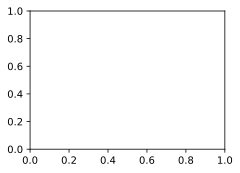

In [29]:
from utils.show import Animator
from utils.tools import Timer, Accumulator
from utils.bbox import multibox_target
num_epochs, timer = 20, Timer()
animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = Accumulator(4)
    net.train()
    for features, target in train_dataloader:
        timer.start()
        optimizer.zero_grad()
        X, Y = features.to(device), target.to(device)

        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)

        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)

        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)

        l.mean().backward() # 这里是默认对第一个维度做平均，即对batchsize做平均

        optimizer.step()
        metric.add(
            cls_eval(cls_preds, cls_labels),
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )

    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

    # animator.add(epoch + 1, (cls_err, bbox_mae))
    print(f"{epoch + 1} epoch, class error = {cls_err}, bbox mae = {bbox_mae}")

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_dataloader.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

> 用GPU训练了三个epoch，花了2h21min40s，觉得太花时间了，可视化看一下结果如何。而在自己电脑上训练的一般都达到到了1e-3的精度，事实说明自己代码的优化程度还不够，就这样去跑太慢了。

### 评估结果

这里先上传助教发的`starting_kit.zip`到工作区中。

In [30]:
!unzip starting_kit.zip

Archive:  starting_kit.zip
   creating: starting_kit/
  inflating: starting_kit/read_dataset.ipynb  
  inflating: starting_kit/test.csv   


In [31]:
!rm starting_kit.zip

In [32]:
import pandas as pd
submit_sample = pd.read_csv('starting_kit/test.csv', header = 0)

In [35]:
import torchvision
net.eval()
img_idx = 0
show_img_id = submit_sample['image_id'][img_idx]
X = torchvision.io.read_image('./dl_detection/test/' + '%07d.jpg'%show_img_id).unsqueeze(0).float()
X.shape

torch.Size([1, 3, 169, 640])

In [36]:
# 将X的宽高缩放到256
img = torchvision.transforms.Resize((256, 256))(X)
img.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 256, 256])

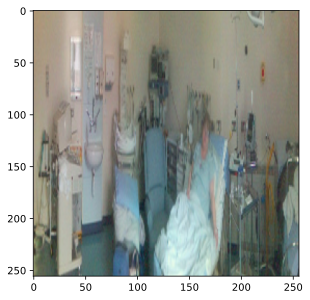

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# 显示img
plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy().astype(np.uint8))
plt.show()

In [40]:
from torch.nn import functional as F
from utils.bbox import multibox_detection
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1) # 利用softmax转换成概率
    output = multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [49]:
output.shape

torch.Size([1649, 6])

In [51]:
output[:5] # 这里的每一行的第一个元素是类别，第二个元素是conf，后面四个元素是bbox的坐标

tensor([[ 0.0000e+00,  1.0000e+00,  2.0952e+02, -6.5400e+02,  2.0952e+02,
         -6.5400e+02],
        [ 0.0000e+00,  1.0000e+00,  1.1057e+00, -7.3212e+04,  1.1063e+00,
          7.3213e+04],
        [ 0.0000e+00,  1.0000e+00,  1.0678e+00,  5.2318e-01,  1.0678e+00,
          5.2318e-01],
        [ 0.0000e+00,  1.0000e+00,  3.8037e-01,  7.8938e-02,  3.8063e-01,
          8.6859e-01],
        [ 0.0000e+00,  1.0000e+00,  3.6296e-01,  4.4082e-01,  3.6297e-01,
          4.4093e-01]], device='cuda:0', grad_fn=<SliceBackward0>)

## 小结

最终的预测结果也并不是非常好，下一步我们决定使用mmdetection框架来试试，并看看效果如何。